## HW \#2: Motion Planning with RRT and Variants
<p style="position: relative; top:-20px; margin: 0px; padding 0px; font-size: 12px">(C) 2023 Bradley Hayes, University of Colorado Boulder</p>
<p style="position: relative; top:-20px; margin: 0px; padding 0px; font-size: 4px">v2023F-1.0</p>

**Deliverable**: A completed Jupyter notebook in both ipynb and PDF format (make sure your generated images are included) uploaded to Canvas. The starter code will generate the necessary images, please do not modify any code that visualizes results.

**Graduate Students**: Please complete the entire assignment.

**Undergraduate Students**: Please complete questions that do not have **(GRAD)** next to them. (You may attempt these for extra credit)

In [1]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import hw2_rrt
from hw2_rrt import Node

In [2]:
name="Nicolas Perrault" # TODO: Replace with your name
print("Name: " + name)
GRAD = False # TODO: set to True if Graduate Student, False otherwise

Name: Nicolas Perrault


In [3]:
# %pip install numpy matplotlib

RRT and its variants produce a graph that approximates a continuous space, typically for the purpose of motion planning in high dimensional domains where complete (and optimal) methods fail. Adding difficulty to this problem is the fact that it is rare for our robot platforms to be holonomic, which is when their mechanical degrees of freedom completely cover the degrees of freedom of the environment they operate in and the order of motor actuations does not have an impact on final position. For this reason, it is common to use sampling-based algorithms like those in the RRT family in two ways:
  
  
1. Waypoints: Assuming a holonomic robot, use RRT to provide a sequence of intermediate environment position goals for the robot on the way to the goal state, which the robot will reach by employing a separate controller (e.g., assume holonomic with the use of a PID controller or other local planner)

2. Direct Control: Compute a sequence of control inputs directly using the RRT algorithm, by using a **model** of the robot to ensure each edge represents a feasible state transition that the robot can execute.

### [5 pts undergraduate, 1 pt graduate] Rapidly-Exploring Random Trees 
First, you will implement the RRT algorithm. We will put this code in the aptly named function ```rrt```. Despite Python being a dynamically typed language, we live in a society with rules and order, and as such we will use type hints wherever possible. Please use these to help inform your implementation. Before we jump into the main algorithm, we need to add code to implement the general-purpose ```get_nearest_vertex``` and ```steer_holonomic``` functions (any valid implementation will do). Within your ```rrt``` implementation, a function named ```steer``` is passed in that you will use for the algorithm. Our test scripts will automatically populate this with the appropriate steer function you've implemented, as you will implement both a holonomic version here and a more complex version further on.

Make use of the provided ```Node``` class, with the following built-in functions:  
   Constructor: ```Node(point: np.ndarray, parent: Node=None)```  
   Member Variables:
   - ```point``` (np.ndarray) -- The point in state space represented by this Node object
   - ```parent``` (Node) -- The Preceeding Node that this Node connects to
   - ```path_from_parent``` (np.ndarray) -- Vector of points indicating a valid path from the parent node's point to this node's point. (e.g., a vector of vectors)
    
***Points will be deducted for solutions that do not generalize to n-dimensional state spaces***  
(treat points as vectors of potentially large dimension, not as x,y coordinates utilizing only (point[0], point[1]))

In [4]:
def get_nearest_vertex(node_list: list[Node], q_point: np.ndarray) -> Node:
    '''
    @param node_list: List of Node objects
    @param q_point: Query point, a numpy array of appropriate dimension
    @return Node in node_list with the closest node.point to the query q_point
    '''
    min_dist = float('inf')
    nearest_node = None
    for node in node_list:
        dist = np.linalg.norm(node.point - q_point)
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    return nearest_node

In [5]:
def steer_holonomic(from_point: np.ndarray, to_point: np.ndarray, delta_q: float) -> np.ndarray:
    '''
    @param from_point: Point where the path to "to_point" is originating from
    @param to_point: Point indicating destination
    @param delta_q: Max path-length to cover
    @returns path: list of points leading from "from_point" to "to_point" (inclusive of endpoints)
    '''
    # Calculate the direction vector from from_point to to_point
    direction_vector = to_point - from_point    
    # Normalize the direction vector to get a unit vector
    unit_direction_vector = direction_vector / np.linalg.norm(direction_vector)
    # Scale the unit vector by delta_q to get a vector of length delta_q
    delta_vector = unit_direction_vector * delta_q
    # Compute the new point by adding the delta_vector to from_point
    new_point = from_point + delta_vector
    return new_point

In [6]:
# Use this area to define any helper functions you'd like to use
def distance(point1: np.ndarray, point2: np.ndarray) -> float:
    '''
    @param point1: Numpy array of appropriate dimension
    @param point2: Numpy array of appropriate dimension
    @return Euclidean distance between point1 and point2
    '''
    distance = 0
    for i in range(len(point1)):
        distance += (point1[i] - point2[i])**2
    return math.sqrt(distance)

def random_point(state_bounds: np.ndarray) -> np.ndarray:
    '''
    @param state_bounds: Numpy array of appropriate dimension
    @return Random point within the bounds given by state_bounds
    '''
    dimensions = len(state_bounds)
    point = np.zeros(dimensions)
    for i in range(dimensions):
        point[i] = random.uniform(state_bounds[i][0], state_bounds[i][1])
    return point

def generate_path(from_point: np.ndarray, to_point: np.ndarray, delta_q: float) -> list[np.ndarray]:
    '''
    @param from_point: Point where the path to "to_point" is originating from
    @param to_point: Point indicating destination
    @param delta_q: Max path-length to cover
    @returns path: list of points leading from "from_point" to "to_point" (inclusive of endpoints)
    '''
    steps = 100
    step_size = delta_q / steps
    path = [from_point]
    # Calculate the direction vector from from_point to to_point
    direction_vector = to_point - from_point    
    # Normalize the direction vector to get a unit vector
    unit_direction_vector = direction_vector / np.linalg.norm(direction_vector)
    for i in range(1, steps):
        delta_vector = unit_direction_vector * step_size * i
        path.append(from_point + delta_vector)
    path.append(to_point)
    return path

def path_is_valid(from_point: np.ndarray, to_point: np.ndarray, delta_q: float, state_is_valid: Callable[[np.ndarray],bool]) -> bool:

    path = generate_path(from_point, to_point, delta_q)
    for point in path:
        if not state_is_valid(point):
            return False
    return True


In [38]:
def rrt(state_bounds: np.ndarray, state_is_valid: Callable[[np.ndarray],bool], starting_point: np.ndarray, goal_point: np.ndarray, steer: Callable[[np.ndarray, np.ndarray, float], np.ndarray], k: int, delta_q: float) -> list[Node]:
    '''
    Implement the RRT algorithm here, making use of the provided function state_is_valid(np.ndarray) -> bool. 
    If goal_point is set, your implementation should return once a path to the goal has been found, 
    using k as an upper-bound. Otherwise, it should build a graph without a goal and terminate after k
    iterations. [NB: Make sure your paths between vertices are valid before adding them!]

    @param state_bounds: matrix of min/max values for each dimension (e.g., [[0,1],[0,1]] for a 2D 1m by 1m square)
    @param state_is_valid: function that maps states (N-dimensional Real vectors) to a Boolean (indicating free vs. forbidden space)
    @param starting_point: Point within state_bounds to grow the RRT from
    @param goal_point: Point within state_bounds to target with the RRT. (OPTIONAL, can be None)
    @param steer: Function steer(from_point, to_point, delta_q) that returns a valid path from from_point to to_point subject to delta_q.
    @param k: Number of points to sample
    @param delta_q: Maximum distance allowed between vertices
    @returns List of RRT graph nodes
    '''

    node_list = []
    node_list.append(Node(starting_point))

    # Your code here. Please use the Node class each vertex in your tree.
    for i in range(k):
        q_rand = random_point(state_bounds)
        nearest_node = get_nearest_vertex(node_list, q_rand)
        q_new = steer(nearest_node.point, q_rand, delta_q)
        if path_is_valid(nearest_node.point, q_new, delta_q, state_is_valid):        
            new_node = Node(q_new, nearest_node)
            new_node.path_from_parent = nearest_node.path_from_parent + [nearest_node.point]
            node_list.append(new_node)
            if goal_point is not None and distance(q_new, goal_point) < delta_q and path_is_valid(q_new, goal_point, delta_q, state_is_valid):
                goal_node = Node(goal_point, new_node)
                goal_node.path_from_parent = new_node.path_from_parent + [q_new]
                node_list.append(goal_node)
                return node_list
            
    return node_list

#### Test Your RRT (no goal) implementation and visualize your graph by running the cells below! 
```test_static``` will always use the same environment, while ```test_random``` will always generate a new environment to try

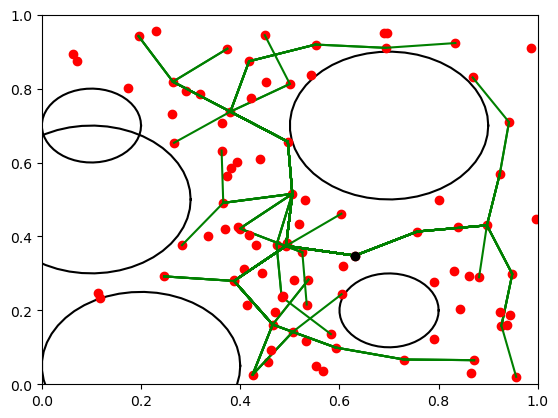

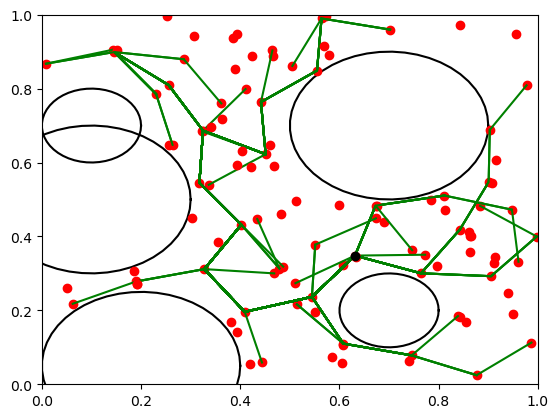

In [8]:
hw2_rrt.test_static_rrt_no_goal([rrt, rrt], steer_holonomic, '01')

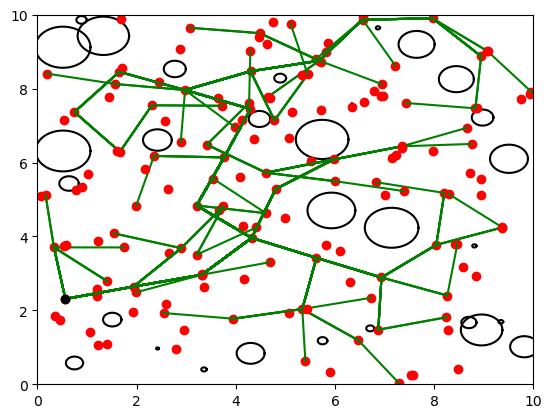

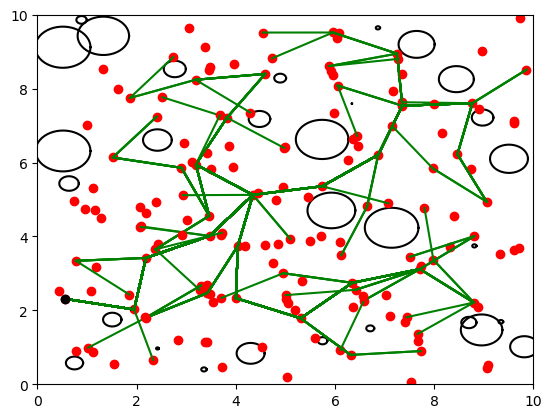

In [9]:
hw2_rrt.test_random_rrt([rrt, rrt], steer_holonomic, '02')

#### Test your goal-directed RRT by running the cells below!

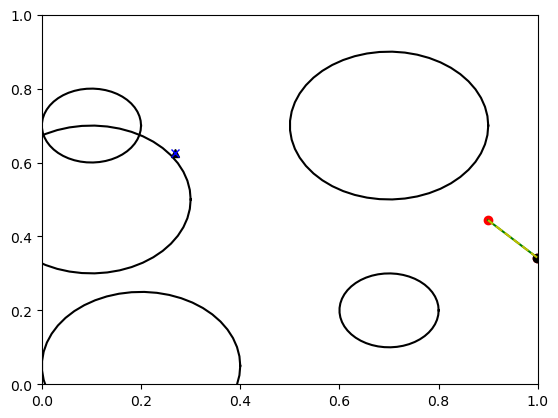

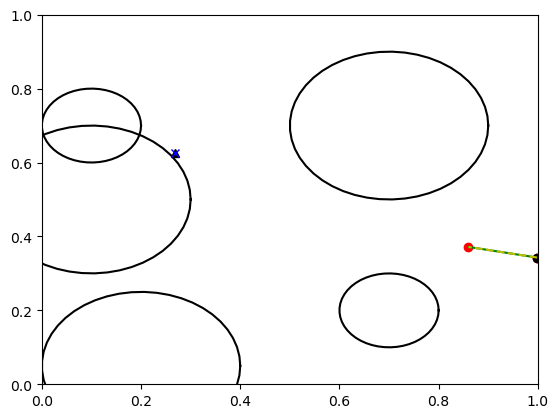

In [41]:
hw2_rrt.test_static_rrt_goal([rrt, rrt], steer_holonomic, '03')

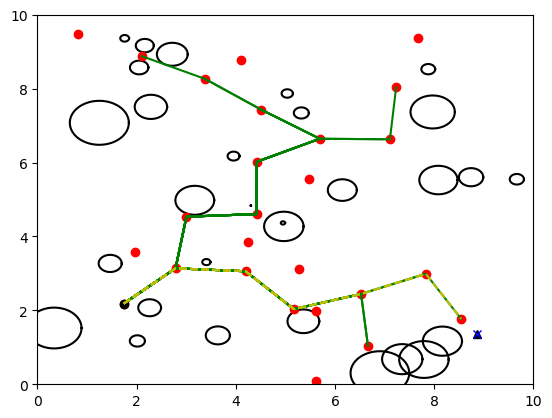

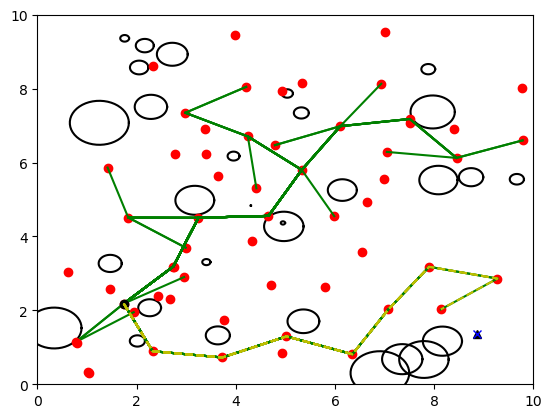

In [11]:
hw2_rrt.test_random_rrt_goal([rrt, rrt], steer_holonomic, '04')

### [5 pts undergraduate, 4 pts graduate] RRT*
Next, you will implement the RRT* algorithm. We will put this code in the function ```rrt_star```. Before we jump into the main algorithm, we need to add code to implement the general-purpose ```get_nearest_vertex``` and ```steer_holonomic``` functions (any valid implementation will do).

Make use of the provided ```Node``` class, with the following built-in functions:  
   Constructor: ```Node(point: np.ndarray, parent: Node=None)```  
   Member Variables:
   - ```point``` (np.ndarray) # The point in state space represented by this Node object
   - ```parent``` (Node) # The Preceeding Node that this Node connects to
   - ```path_from_parent``` (np.ndarray) # List of points indicating a valid path from the parent node's point to this node's point.

In [12]:
def rrt_star(state_bounds: np.ndarray, state_is_valid: Callable[[np.ndarray],bool], starting_point: np.ndarray, goal_point: np.ndarray, steer: Callable[[np.ndarray, np.ndarray, float], np.ndarray], k: int, delta_q: float) -> list[Node]:
    '''
    TODO: Implement the RRT* algorithm here, making use of the provided state_is_valid and steer functions

    @param state_bounds: matrix of min/max values for each dimension (e.g., [[0,1],[0,1]] for a 2D 1m by 1m square)
    @param state_is_valid: function that maps states (N-dimensional Real vectors) to a Boolean (indicating free vs. forbidden space)
    @param k: Number of points to sample
    @param delta_q: Maximum distance allowed between vertices
    @returns List of RRT* graph nodes
    '''

    node_list = []

    node_list.append(Node(starting_point))

    # TODO: Your code here

    return node_list

#### Verify your implementation of RRT* by running the tests below, comparing your RRT and RRT* trees:

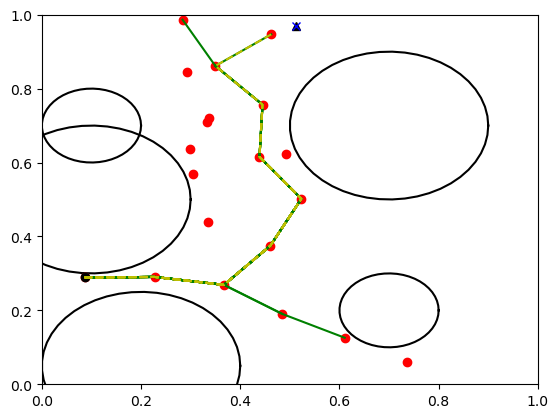

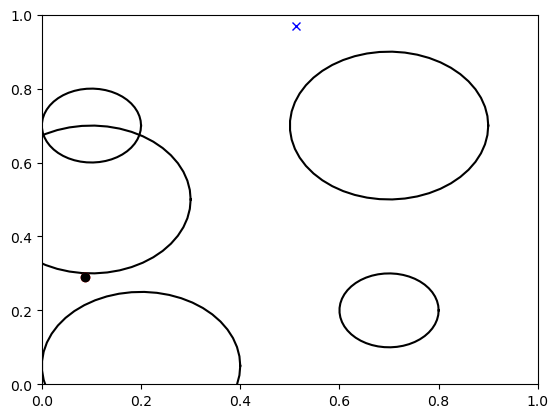

In [13]:
hw2_rrt.test_static_rrt_goal([rrt, rrt_star], steer_holonomic, '05')

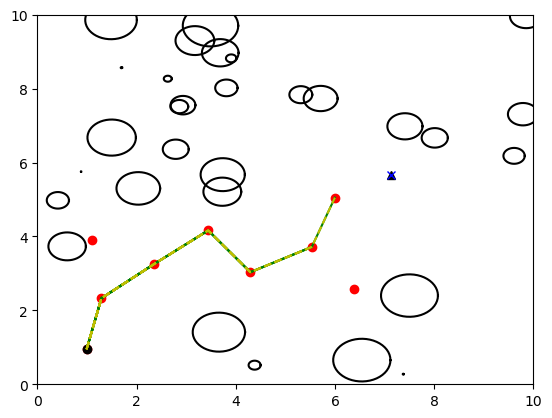

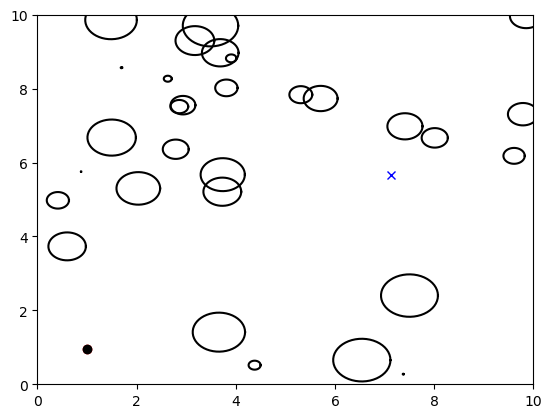

In [14]:
hw2_rrt.test_random_rrt_goal([rrt, rrt_star], steer_holonomic, '06')

### [+2pts Undergraduate, 4pts Graduate] Non-Holonomic RRT (GRAD)
If our robot cannot freely traverse the coordinate system used in our RRT algorithm, then we can't just add vertices wherever we want and interpolate from existing ones (our robot may not be able to take a straight-line path or even get to the new vertex!). Fill in the code for the ```initialize_non_holonomic_actions``` and ```steer_discrete_non_holonomic``` functions implementing a Reeds-Shepp-inspired car model with a discrete action space given as a list ```actions_list```. 

Your vehicle model should support at least six actions: {turn left, drive straight, turn right} for both the forwards and backwards direction. Your vehicle can maintain a maximum steering angle of +/- 60 degrees with speed no greater than 0.25/timestep. Each of these actions is to be represented by a tuple (speed, steering angle) that will be executed over a single, universal timestep each.

In [15]:
def initialize_non_holonomic_actions() -> np.ndarray:
    actions = []

    # TODO: Your code here
    
    return actions

In [16]:
def simulate_non_holonomic_action(start_point: np.ndarray, action: np.ndarray) -> np.ndarray:
    '''
    Returns a discretized path along which the agent moves when performing an action from a given point.    
    @param start_point: A 3-dimensional vector encoding the starting [x,y,theta] of the robot
    @returns path: A list of 3-dimensional points beginning at "start_point" and ending the appropriate distance away
    '''
    path = []
    
    # Hint: Don't worry about finding an analytic solution here- 
    #       we're roboticists and an approximating forward simulation run one (fractional) step at a time is good enough for now

    return np.array(path)

In [17]:
def steer_non_holonomic(from_point: np.ndarray, to_point: np.ndarray, delta_q: float) -> np.ndarray:
    '''
    Given a fixed discrete action space from initialize_non_holonomic_actions and robot model from simulate_non_holonomic_action, 
    choose the action that gets you closest to "to_point" when executing it from "from_point"

    @param from_point: (x,y,theta) vector where the path to "to_point" is originating from
    @param to_point: (x,y,theta) vector indicating desired destination
    @param delta_q: Maximum allowable path length. Truncate your path if its length exceeds delta_q.
    @returns path: list of (x,y,theta) vectors leading from "from_node" to "to_point" (inclusive of endpoints)
    '''
    # Our discrete non-holonomic action space will consist of a limited set of movement primitives.
    # Your code should choose an action from the actions_list and apply it for this implementation
    # of steer. You can simulate an action with simulate_non_holonomic_action
    # which will give you a list of points along the path the agent travels, starting at start_point. 
    # Index -1 (the last element) of the resulting path is where the agent ends up after that action ends.
    
    actions_list = initialize_non_holonomic_actions()
    
    # Hint: Use simulate_non_holonomic_action(state, action) to test actions before choosing one
           
    return np.array([])

#### Test your non-holonomic RRT implementation of a Reeds-Shepp car by running the tests below:

In [18]:
hw2_rrt.test_non_holonomic_rrt([rrt, rrt, rrt_star, rrt_star], steer_non_holonomic, '07')


ValueError: operands could not be broadcast together with shapes (0,) (3,) 

In [ ]:
hw2_rrt.test_non_holonomic_rrt_goal([rrt, rrt, rrt_star, rrt_star], steer_non_holonomic, '08')

### [1pt Undergraduate, 1pt Graduate] Non-Holonomic RRT* (GRAD)
Run the code blocks below to try your RRT* implementation on your non-holonomic vehicle model. In the markdown cell at the end of the notebook, describe why an RRT* solution may have trouble returning a path that's better than a standard RRT solution.

In [ ]:
hw2_rrt.test_non_holonomic_rrt([rrt_star, rrt_star], steer_non_holonomic, '09')


In [ ]:
hw2_rrt.test_non_holonomic_rrt_goal([rrt_star, rrt_star], steer_non_holonomic, '10')

#### My Answer:

